In [1]:
import numpy as np
import pickle
import project_path
import os
from model.neuron_metadata import *
from model.data_accessor import get_data_file_abs_path
from model.neural_model import NeuralModel
from util.plot_util import *
from scipy import optimize
from numpy import linalg as LA
import sympy as sp
import time

neuron_metadata_collection = NeuronMetadataCollection.load_from_chem_json(get_data_file_abs_path('chem.json'))
N = neuron_metadata_collection.get_size()
neuron_to_stimulate = "PLMR"

In [2]:
model = NeuralModel(neuron_metadata_collection)
model.init_kunert_2017()

# Get standard equilibrium
I_nA = 1.4
cur_I_ext = np.zeros(N)
neuron_id = neuron_metadata_collection.get_id_from_name(neuron_to_stimulate)
cur_I_ext[neuron_id] = I_nA * 10000
model.cur_I_ext = cur_I_ext
model.set_I_ext_constant_currents({neuron_to_stimulate: I_nA})
standard_equi = model.compute_standard_equilibrium()

In [19]:
def get_dynamics_symbols(model):
  """
  Get the dV/dt and dS/dt in symbols, so you can do things like substitutions / computing jacobians.
  """
  N = model.N
  vsymbols = sp.symbols(' '.join([('v'+str(i)) for i in range(N)]))
  ssymbols = sp.symbols(' '.join([('s'+str(i)) for i in range(N)]))
  vthsymbols = sp.symbols(' '.join([('vth'+str(i)) for i in range(N)]))
  vs = sp.Matrix(vsymbols)
  ss = sp.Matrix(ssymbols)
  vths = sp.Matrix(vthsymbols)

  Gs_sp = sp.Matrix(model.Gs)
  Gg_sp = sp.Matrix(model.Gg)
  E_sp = sp.Matrix(model.E)
  Gg_squashed_col_sp = sp.Matrix(model.Gg.sum(axis = 1))
  neg_Ec_sp = sp.ones(N,1) * (-model.Ec)

  # I_leak
  I_leak = model.Gc * (vs + neg_Ec_sp)

  # I_gap = sum_j G_ij (V_i - V_j) = V_i sum_j G_ij - sum_j G_ij V_j
  # The first term is a point-wise multiplication of V and G's squashed column.
  # The second term is matrix multiplication of G and V
  I_gap = sp.matrix_multiply_elementwise(Gg_squashed_col_sp, vs) - Gg_sp * vs

  # I_syn = sum_j G_ij s_j (V_i - E_j) = V_i sum_j G_ij s_j - sum_j G_j s_j E_j
  # First term is a point-wise multiplication of V and (Matrix mult of G and s)
  # Second term is matrix mult of G and (point mult of s_j and E_j)
  I_syn = sp.matrix_multiply_elementwise(vs, Gs_sp * ss) -\
      Gs_sp * sp.matrix_multiply_elementwise(ss, E_sp)

  dV_dts = (-I_leak - I_gap - I_syn + sp.Matrix(model.cur_I_ext)) / model.C
  
  v_min_vths = vs - vths
  phis = v_min_vths.applyfunc(lambda v_min_vth: 1.0 / (1.0 + sp.Pow(np.e, -model.B * v_min_vth)))
  syn_rises = model.ar * sp.matrix_multiply_elementwise(phis, (sp.ones(N,1) - ss))
  syn_drops = model.ad * ss
  dS_dts = syn_rises - syn_drops
  return vsymbols, ssymbols, vthsymbols, sp.Matrix([dV_dts, dS_dts])

In [20]:
start_time = time.time()
vsymbols, ssymbols, vthsymbols, dyn_symbols = get_dynamics_symbols(model)
print("Computing symbols takes %.2fs" % (time.time() - start_time))

Computing symbols takes 9.15s


In [21]:
# This shows that our symbolic dynamics calculation matches that from the original model
# We did our symbols correctly!

# Evaluated dV/dt at standard equilibrium
test_state_vars_1 = list(range(2*N))
test_state_vars = test_state_vars_1
sub_dict = {vsymbols[i]: test_state_vars[i] for i in range(N)}
sub_dict.update({ssymbols[i]: test_state_vars[i+N] for i in range(N)})
sub_dict.update({vthsymbols[i]: model.Vth[i] for i in range(N)})

dyns_from_symbol = dyn_symbols.xreplace(sub_dict)
dyns_from_model = model.dynamic(t=0, state_vars = np.array(test_state_vars))
print(dyns_from_symbol[0:5])
print(dyns_from_model[0:5])
print(dyns_from_symbol[-5:])
print(dyns_from_model[-5:])
print(np.mean(np.abs(np.array(list(dyns_from_symbol)) - np.array(dyns_from_model))))

[-350.000000000000, -30460.0000000000, -349370.000000000, -743180.000000000, -1831790.00000000]
[-3.50000e+02 -3.04600e+04 -3.49370e+05 -7.43180e+05 -1.83179e+06]
[-3316.99999913167, -3323.00000000000, -2775.00000000000, -3335.00000000000, -3040.09698988484]
[-3316.99999913 -3323.         -2775.         -3335.
 -3040.09698988]
2.19168052881873e-9


/home/stephen/Documents/code/c-elegans-discrete-neural/model/neural_model.py:226: RuntimeWarning: overflow encountered in exp
  phi = 1.0/(1.0 + np.exp(-self.B*(v_arr - self.Vth)))


In [22]:
start_time = time.time()
all_symbols = list(vsymbols) + list(ssymbols)
J = sp.Matrix(dyn_symbols).jacobian(all_symbols)
print("Computing symbolic jacobian takes %.2fs" % (time.time() - start_time))

Computing symbolic jacobian takes 27.46s


# Compute Jacobian eigenvalues as PLMR input is varied

Note that we just keep using the same symbolic jacobian for all input. This is because I_ext will get differentiated away in the jacobian matrix. The only thing that changes with I_nA is the standard equilibrium.

From manual testing, somewhere between 1.75 and 1.85 nA, we get Hopf bifurcation.

In [24]:
J_lambda = sp.lambdify(list(vsymbols) + list(ssymbols) + list(vthsymbols), J, 'numpy')

In [35]:
print("I_nA, max_real_eval")
I_nAs = np.arange(0.1,3.0,0.01)
max_real_eigenvalues = []
for I_nA in I_nAs:
  model = NeuralModel(neuron_metadata_collection)
  model.init_kunert_2017()

  # Get standard equilibrium
  cur_I_ext = np.zeros(N)
  neuron_id = neuron_metadata_collection.get_id_from_name(neuron_to_stimulate)
  cur_I_ext[neuron_id] = I_nA * 10000
  model.cur_I_ext = cur_I_ext
  model.set_I_ext_constant_currents({neuron_to_stimulate: I_nA})
  
  standard_equi = model.compute_standard_equilibrium()
  
  start_time = time.time()
  j_np = J_lambda(*(list(standard_equi) + list(model.Vth)))
  
  # Uncomment below if you don't want to use lambdify. But... lambdify is much faster! From 2s to 0.05s.
  """
  sub_dict = {vsymbols[i]: standard_equi[i] for i in range(N)}
  sub_dict.update({ssymbols[i]: standard_equi[i+N] for i in range(N)})
  evaluated_j = J.xreplace(sub_dict)
  j_np = np.array(evaluated_j).astype(np.float64)
  """
  print("Evaluating jacobian takes %.2fs" % (time.time() - start_time))
  
  evals = LA.eigvals(j_np)
  max_real_eigenvalue = np.max(evals)
  print("%.2f, %.2f" % (I_nA, max_real_eigenvalue))
  max_real_eigenvalues.append(max_real_eigenvalue)

I_nA, max_real_eval
Evaluating jacobian takes 0.08s
0.10, -4.60


/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: ComplexWarning: Casting complex values to real discards the imaginary part


Evaluating jacobian takes 0.02s
0.11, -4.60
Evaluating jacobian takes 0.02s
0.12, -4.60
Evaluating jacobian takes 0.03s
0.13, -4.61
Evaluating jacobian takes 0.02s
0.14, -4.61
Evaluating jacobian takes 0.02s
0.15, -4.61
Evaluating jacobian takes 0.02s
0.16, -4.61
Evaluating jacobian takes 0.02s
0.17, -4.61
Evaluating jacobian takes 0.04s
0.18, -4.62
Evaluating jacobian takes 0.03s
0.19, -4.62
Evaluating jacobian takes 0.02s
0.20, -4.62
Evaluating jacobian takes 0.02s
0.21, -4.62
Evaluating jacobian takes 0.02s
0.22, -4.62
Evaluating jacobian takes 0.02s
0.23, -4.63
Evaluating jacobian takes 0.02s
0.24, -4.63
Evaluating jacobian takes 0.02s
0.25, -4.63
Evaluating jacobian takes 0.02s
0.26, -4.64
Evaluating jacobian takes 0.02s
0.27, -4.64
Evaluating jacobian takes 0.02s
0.28, -4.65
Evaluating jacobian takes 0.02s
0.29, -4.65
Evaluating jacobian takes 0.02s
0.30, -4.66
Evaluating jacobian takes 0.02s
0.31, -4.66
Evaluating jacobian takes 0.03s
0.32, -4.67
Evaluating jacobian takes 0.02s


1.97, 0.55
Evaluating jacobian takes 0.02s
1.98, 0.59
Evaluating jacobian takes 0.02s
1.99, 0.62
Evaluating jacobian takes 0.02s
2.00, 0.65
Evaluating jacobian takes 0.02s
2.01, 0.68
Evaluating jacobian takes 0.02s
2.02, 0.71
Evaluating jacobian takes 0.02s
2.03, 0.74
Evaluating jacobian takes 0.04s
2.04, 0.78
Evaluating jacobian takes 0.02s
2.05, 0.81
Evaluating jacobian takes 0.02s
2.06, 0.84
Evaluating jacobian takes 0.02s
2.07, 0.87
Evaluating jacobian takes 0.02s
2.08, 0.90
Evaluating jacobian takes 0.03s
2.09, 0.93
Evaluating jacobian takes 0.03s
2.10, 0.96
Evaluating jacobian takes 0.03s
2.11, 1.00
Evaluating jacobian takes 0.02s
2.12, 1.03
Evaluating jacobian takes 0.03s
2.13, 1.06
Evaluating jacobian takes 0.03s
2.14, 1.09
Evaluating jacobian takes 0.03s
2.15, 1.12
Evaluating jacobian takes 0.03s
2.16, 1.15
Evaluating jacobian takes 0.03s
2.17, 1.18
Evaluating jacobian takes 0.03s
2.18, 1.22
Evaluating jacobian takes 0.03s
2.19, 1.25
Evaluating jacobian takes 0.03s
2.20, 1.28


/home/stephen/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'Max real eigenvalue')

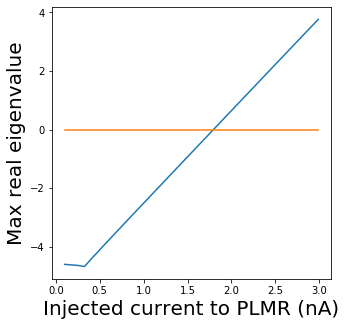

In [44]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(I_nAs, max_real_eigenvalues)
ax.plot(I_nAs, [0] * len(I_nAs))
ax.set_xlabel("Injected current to PLMR (nA)", fontsize=20)
ax.set_ylabel("Max real eigenvalue", fontsize=20)

# Compute Jacobian eigenvalues using scipy's approximate fprime

In [28]:
from scipy import optimize
I_nA = 3.0
epsilon = 0.0001

In [29]:
model = NeuralModel(neuron_metadata_collection)
model.init_kunert_2017()

# Get standard equilibrium
cur_I_ext = np.zeros(N)
neuron_id = neuron_metadata_collection.get_id_from_name(neuron_to_stimulate)
cur_I_ext[neuron_id] = I_nA * 10000
model.cur_I_ext = cur_I_ext
model.set_I_ext_constant_currents({neuron_to_stimulate: I_nA})
standard_equi = model.compute_standard_equilibrium()

jacobian_rows = []
start_time_s = time.time()
for i in range(2 * N):
  print(i)
  # TODO: Optimize this by caching? Each index i incurs ~600 calls.
  dvs_dt = lambda state_vars: model.dynamic(t=0, state_vars=state_vars)[i]
  jacobian_row = optimize.approx_fprime(standard_equi, dvs_dt, epsilon)
  jacobian_rows.append(jacobian_row)
print("Evaluating jacobian takes %.2f s" % (time.time() - start_time_s))
jacobian_mat = np.array(jacobian_rows)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [30]:
eigenvalues = LA.eigvals(jacobian_mat)
print(max(eigenvalues))

(3.796399143284891+6.457241547913635j)


In [130]:
jacobian_mat[-5:,-5:]

array([[-5.5,  0. ,  0. ,  0. ,  0. ],
       [ 0. , -5.5,  0. ,  0. ,  0. ],
       [ 0. ,  0. , -5.5,  0. ,  0. ],
       [ 0. ,  0. ,  0. , -5.5,  0. ],
       [ 0. ,  0. ,  0. ,  0. , -5.5]])